# Kalman-Stan

In [72]:
rm(list = ls())
library(rstan)
library(reshape2)
library(ggplot2)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In many settings, the permanent and transitory component of an aggregate time series (like labour income) is estimated by writing up a state space representation, and computing the smoothed state estimate.

This notebook shows an example of how **Stan** could be used to calculate the joint posterior distrubution of all the variables we are interested in, and compares it with the closed form solution provided by the classical Kalman filter.

In the following example, the permanent component of a series follows a random walk, while the transitory component is white noise. The classical state space formulation is:

Observation equation

$y_t = w_{t-1} + \eta_t$

Process equation

$w_t = w_{t-1} + k_t$

$\eta_t \sim N(0, \sigma_{\eta}^2) \quad k_t \sim N(0, \sigma_k^2)$

Using the Kalman filter, one can compute the optimal filtered and smoothed state estimates as (using the usual notational convention for the expected state means and with a stationary process variance) 

Filtering (forward pass), for t=2:T

$\hat w_{t+1|t} = (1-K)  \hat w_{t|t} + K y_t  $

Smoothing (backward pass), for t=(T-1):1

$\hat w_{t|T} = (1-K)  \hat w_{t|t} + L \hat w_{t|T+1}   $

where

$ P = 0.5( \sqrt{ \sigma_k^4 + 4 \sigma_\eta^2 \sigma_k^2} - \sigma_k^2)$

$ K = \frac{P + \sigma_k^2}{P + \sigma_k^2 + \sigma_\eta^2} $

$ L = \frac{P}{P + \sigma_k^2} $

We can use this to evalue the conditonal likelihood $f(y_{t+1} | y_t)$ which will be normal with mean $w_t$ and variance 
$P + \sigma_\eta^2 + \sigma_k^2$ and estimate $(\sigma_\eta, \sigma_k^2)$ by maximum likelihood (i.e. $\mathrm{arg max} \sum_t^T \mathrm {log} (f(y_{t+1} | y_t, \sigma_\eta, \sigma_k))  $)

#### A simple encapsulation of the above Kalman equations i R is

In [82]:
kalman = function(y, sigmaeta, sigmak, w0=0, smoothed = FALSE) {    
    P = 0.5 *(sqrt(sigmak^4 + 4 * sigmaeta^2 * sigmak^2) - sigmak^2)
    K = (P + sigmak^2) / (P + sigmak^2 + sigmaeta^2)
    L = P / (P + sigmak^2)
    
    nT = length(y)
    w = rep(w0, nT) # initialized with the stationary mean
    for (t in 2:nT)
       w[t] = (1 - K) * w[t-1] + K * y[t]
    
    if (smoothed) {
         w_smoothed = w
        for (t in (nT-1):1)
            w_smoothed[t] = (1 - L) * w[t] + L * w_smoothed[t+1]
    } else
        w_smoothed = NA
    
    list(w = w, w_smoothed = w_smoothed,
        P = P, K = K, L = L)
}

#### The loglikelihood function for the sample is

In [83]:
loglik = function(params, y) {
    sigmaeta = params[1]
    sigmak = params[2]
    nT = length(y)
    k = kalman(y, sigmaeta, sigmak)
    
    -sum(dnorm(y[2:nT],
              mean = k$w[1:(nT-1)],
              sd = sqrt(k$P + sigmaeta^2 + sigmak^2),
              log = TRUE))
}

#### Simulate some ground truth

In [115]:
set.seed(123)
nT = 100
sigmaeta = 1.3
sigmak = 0.5

eta = rnorm(nT, 0, sigmaeta)
w = rep(0, nT)
for (t in 2:nT)
  w[t] = w[t-1] + rnorm(1, 0, sigmak)

y = w + eta

#### Maximize the likelihood

In [116]:
opt = optim(c(10, 10), function(x) loglik(x, y),
            method = 'L-BFGS', lower = 0.00001)

#### Which gives

In [117]:
opt$par[1]
opt$par[2]

[1] 1.254285

[1] 0.4263385

#### With Stan

We can also calculate the smoothed posterior distribution of the state variable using Stan. One formulation of a Stan model corresponding to the above state space model is:

```
data {
  int T;
  vector[T] Y;
}

parameters {
  real<lower=0> sigmaeta;
  real<lower=0> sigmak;
  vector[T] eta;
  vector[T] w;
}

model {
  sigmaeta ~ normal(0, 1);
  sigmak ~ normal(0, 1);

  w[1] ~ normal(0, 0.1);
  w[2:T] ~ normal(w[1:(T-1)], sigmak);
  eta ~ normal(0, sigmaeta);

  Y ~ normal(w + eta, sigmak + sigmaeta);
}
```

(note that doing filtering is not currently possible, as far as I know)

#### Compile the model and draw 5000 samples from the posterior distrubution

In [122]:
fit = stan(file = 'kalmanstan.stan',
           data = list(Y = y, T = nT),
           iter = 5000, chains = 4)

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from file791bbea974d.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/BH/include/boost/math/tools/config.hpp:13:
In file included from /

The estimate for $\sigma_\eta$ is clearly consitent, but $\sigma_k$ is not identified

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


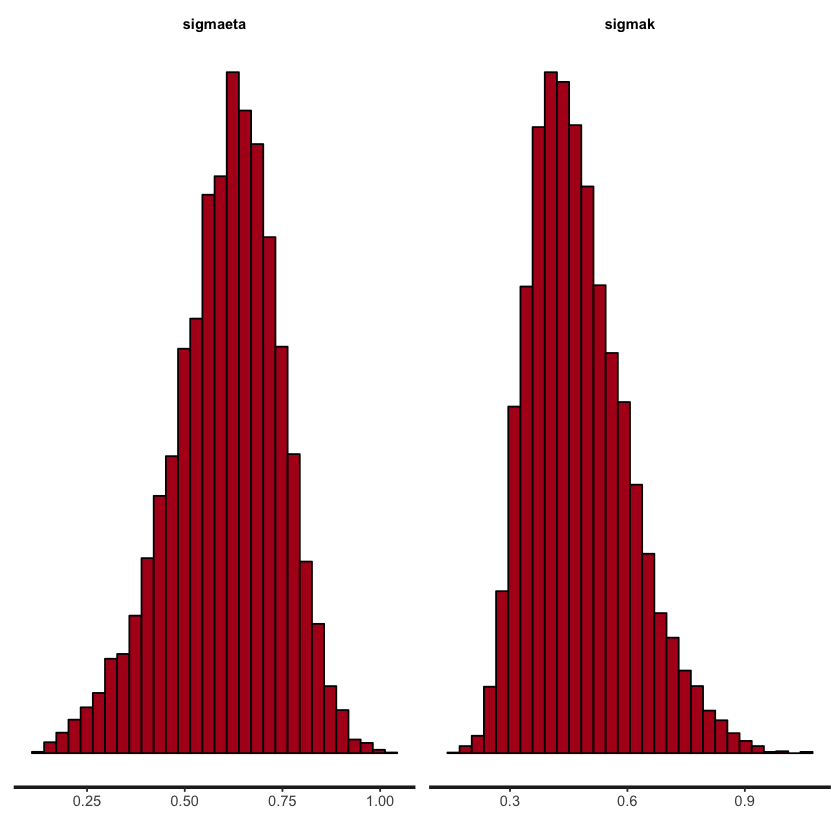

In [124]:
stan_hist(fit, pars=c('sigmaeta', 'sigmak'))

#### However, the two smoothed state estimates are extremely close

The red line is the simualted permanent component of y.

The blue line is the smoothed state estimate using the Kalman filter, with parameters estimated by maximum likelihood.

The green line is the mean of the (joint) posterior distribution of the state and all other variables.

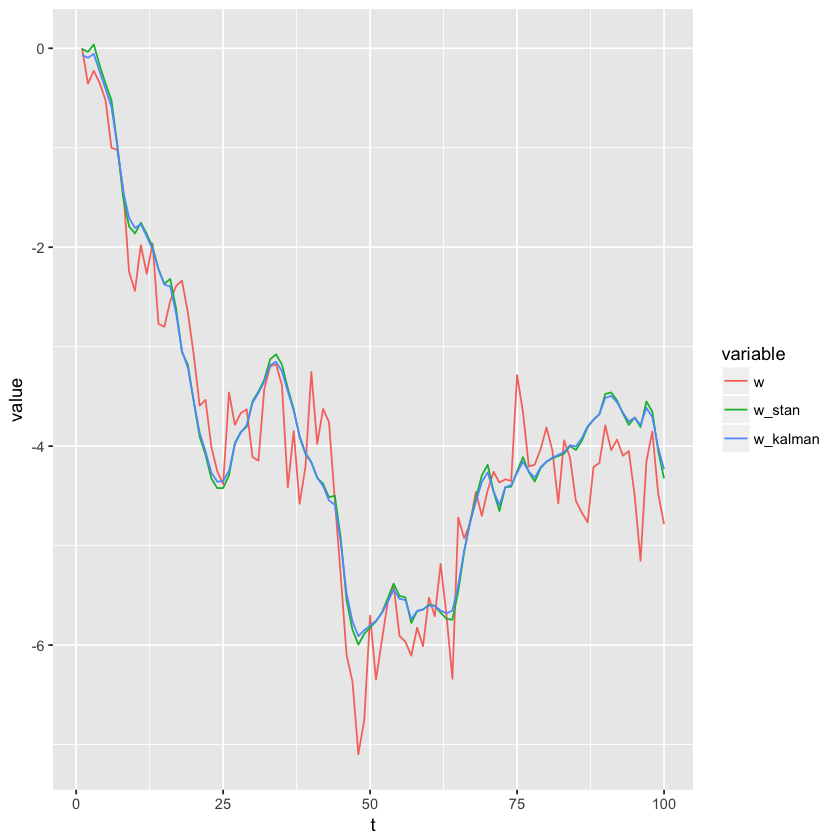

In [125]:
samples = extract(fit)
df = data.frame(w = w,
                w_stan = colMeans(samples$w),
                w_kalman = kalman(y, opt$par[1], opt$par[2], smoothed = TRUE)$w_smoothed,
                t = 1:nT)


ggplot(melt(df, id.vars = 't')) + 
    geom_line(aes(x = t, y = value, color = variable))